- generate random objects of different signal absorption rate
- generate random lines between points outside of these objects
- draw lines into estimation image based on the average signal absorption along the line

In [142]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import correlation

In [164]:
# area size
length = 130
# area margin at the border where no objects are placed
margin_border = 2

# object size
min_size = 3
max_size = 20
# object absorbtion rates
min_absorption = 3
max_absorption = 20
# number of objects placed in area
n_objs = 100

# number of measurement lines placed in area
n_lines = 50000

# percentages of used lines at which we plot and measure eastimations
number_of_lines_estimation = [100, 500, 1000, 20000, 50000]
# signal losses to plot and measure estimations at
signal_losses_estimation = [200, 1000]

In [165]:
class Object:
    def __init__(self):
        self.width = random.randint(min_size, max_size)
        self.height = random.randint(min_size, max_size)
        self.x = random.randint(margin_border, length-margin_border-self.width)
        self.y = random.randint(margin_border, length-margin_border-self.height)
        self.absorption = random.randint(min_absorption, max_absorption)

def get_pos(border, pos):
    if border == 0:
        return pos, 0
    if border == 1:
        return length-1, pos
    if border == 2:
        return pos, length-1
    return 0, pos
    
class LineBorder:
    def __init__(self):
        borders = random.sample(range(-1, 3), 2)
        pos = (random.randint(0, length-1), random.randint(0, length-1))
        x0, y0 = get_pos(borders[0], pos[0])
        x1, y1 = get_pos(borders[1], pos[1])
        self.length = int(np.hypot(x1-x0, y1-y0))
        self.x, self.y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)
        
class LineOutsideObjects:
    def __init__(self, background_positions):
        positions = random.sample(background_positions, 2)
        x0, y0 = positions[0]
        x1, y1 = positions[1]
        self.length = int(np.hypot(x1-x0, y1-y0))
        self.x, self.y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)
        
def accumulate_lines(lines, num_lines, signal_lost_threshold=None):
    res = []
    sums = np.zeros(shape=(length, length), dtype=float)
    counts = np.zeros(shape=(length, length), dtype=float)
    for line_i, line in enumerate(lines):
        for num_line in num_lines:
            if num_line-1 == line_i:
                out = np.copy(sums)
                out[counts > 0] = out[counts > 0] / counts[counts > 0]
                res.append(out)
        values = gt[line.x.astype(int), line.y.astype(int)]
        num_values = len(values)
        absorbtion_sum = np.sum(values)
        if signal_lost_threshold is not None and absorbtion_sum > signal_lost_threshold:
            # the signal is completely absorbed along the way
            absorbtion_sum = signal_lost_threshold
        sums[line.x.astype(int), line.y.astype(int)] += absorbtion_sum
        counts[line.x.astype(int), line.y.astype(int)] += 1

    return res


In [166]:
random_objs = [Object() for i in range(n_objs)]

In [167]:
gt = np.zeros(shape=(length, length), dtype=int)
for obj in random_objs:
    gt[obj.x:obj.x+obj.width, obj.y:obj.y+obj.height] = obj.absorption

## Measuring from outside

All measurement lines in the next section start and end on the boundary of the area.

In [168]:
random_lines_border = [LineBorder() for i in range(n_lines)]

In [169]:
line_estimates_border = accumulate_lines(random_lines_border, number_of_lines_estimation)

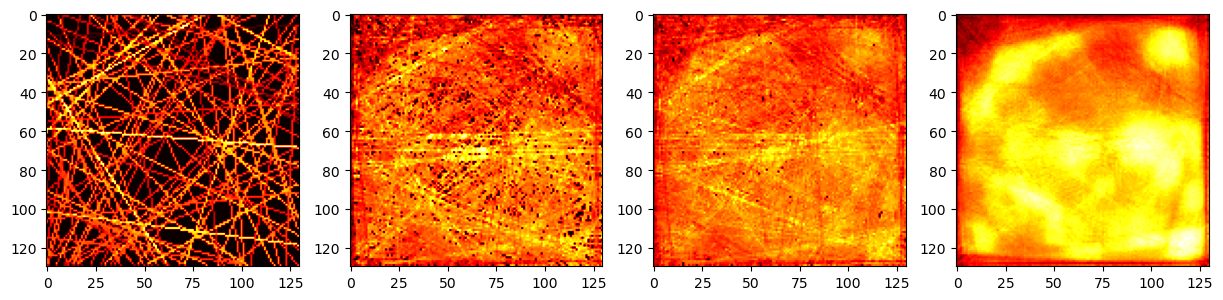

In [170]:
fig, axes = plt.subplots(ncols=4, figsize=(15, 15))
axes[0].imshow(line_estimates_border[0], cmap='hot')
axes[1].imshow(line_estimates_border[1], cmap='hot')
axes[2].imshow(line_estimates_border[2], cmap='hot')
axes[3].imshow(line_estimates_border[3], cmap='hot')
plt.show()

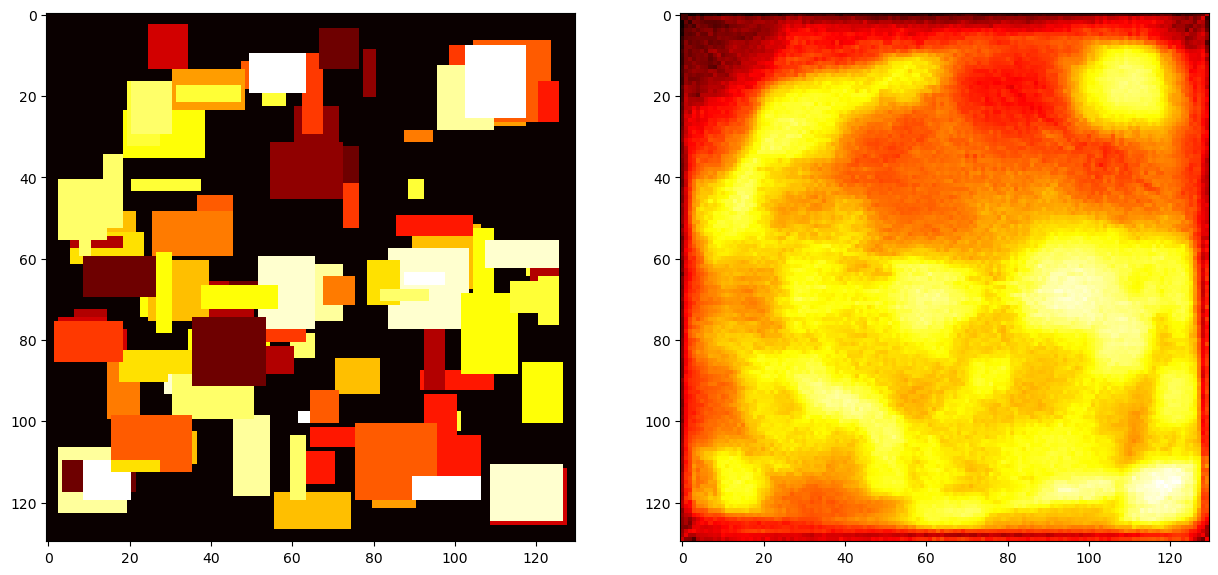

In [171]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 15))
axes[0].imshow(gt, cmap='hot')
axes[1].imshow(line_estimates_border[len(number_of_lines_estimation)-1], cmap='hot')
plt.show()

## Adding signal loss

The absorbtion rate along lines is clipped at a specific value - higher absorbtion equals signal loss and can't be measured.

In [172]:
line_estimates_border_losses = [accumulate_lines(random_lines_border, number_of_lines_estimation, signal_lost_threshold=threshold) for threshold in signal_losses_estimation]

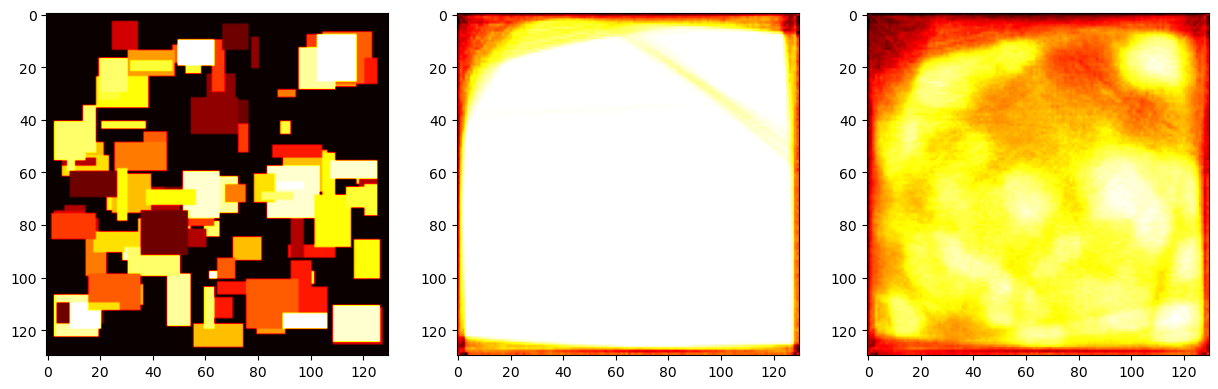

In [174]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 15))
axes[0].imshow(gt, cmap='hot')
axes[1].imshow(line_estimates_border_losses[0][len(number_of_lines_estimation)-1], cmap='hot')
axes[2].imshow(line_estimates_border_losses[1][len(number_of_lines_estimation)-1], cmap='hot')
plt.show()

## Measuring from anywhere
What if measurements can be taken between any two points in the area, not just the boundary?

In [175]:
background_positions = np.argwhere(gt==0).tolist()
random_lines_anywhere = [LineOutsideObjects(background_positions) for i in range(n_lines)]

In [176]:
line_estimates_anywhere = accumulate_lines(random_lines_anywhere, number_of_lines_estimation)

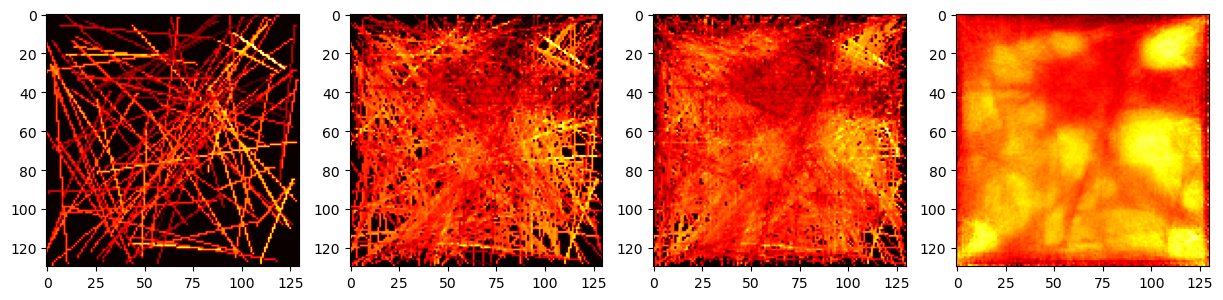

In [177]:
fig, axes = plt.subplots(ncols=4, figsize=(15, 15))
axes[0].imshow(line_estimates_anywhere[0], cmap='hot')
axes[1].imshow(line_estimates_anywhere[1], cmap='hot')
axes[2].imshow(line_estimates_anywhere[2], cmap='hot')
axes[3].imshow(line_estimates_anywhere[3], cmap='hot')
plt.show()

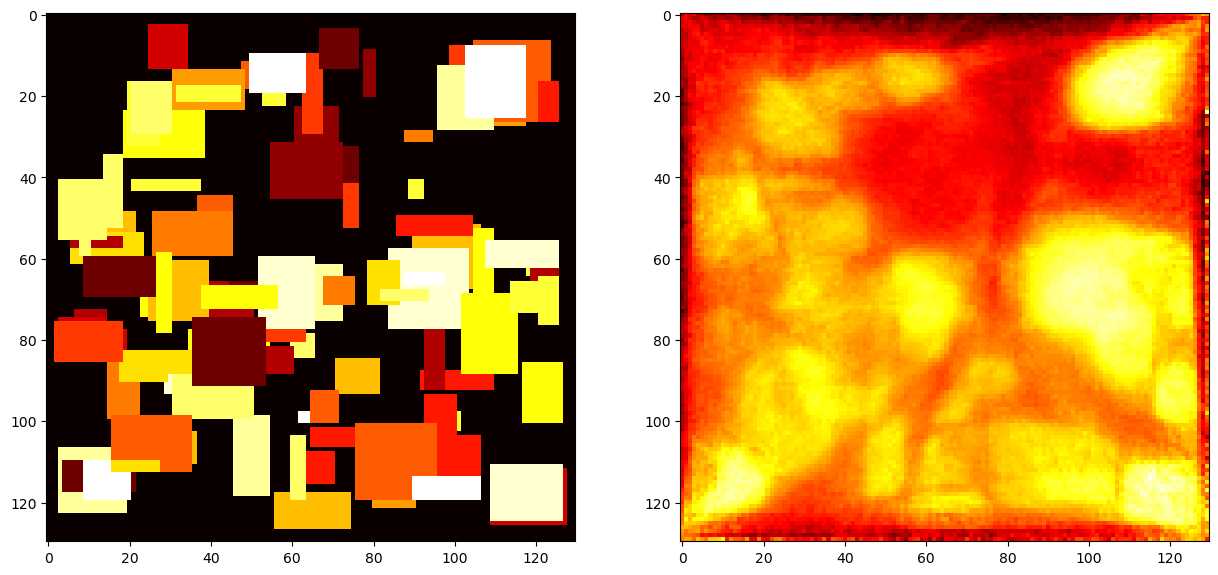

In [178]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 15))
im0 = axes[0].imshow(gt, cmap='hot')
im1 = axes[1].imshow(line_estimates_anywhere[len(number_of_lines_estimation)-1], cmap='hot')
plt.show()

## Measuring from anywhere with signal loss

In [179]:
line_estimates_anywhere_losses = [accumulate_lines(random_lines_anywhere, number_of_lines_estimation, signal_lost_threshold=threshold) for threshold in signal_losses_estimation]

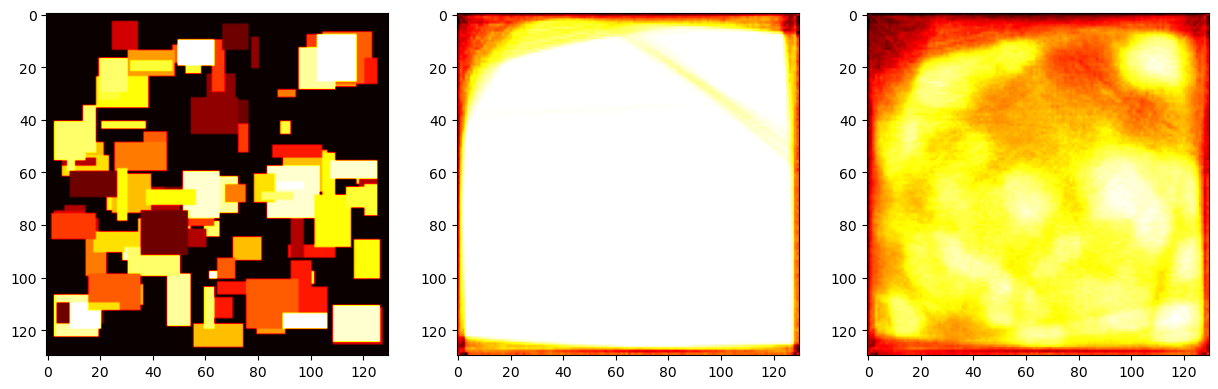

In [180]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 15))
axes[0].imshow(gt, cmap='hot')
axes[1].imshow(line_estimates_border_losses[0][len(number_of_lines_estimation)-1], cmap='hot')
axes[2].imshow(line_estimates_border_losses[1][len(number_of_lines_estimation)-1], cmap='hot')
plt.show()

## Correlation

In [181]:
correlation_baseline = [correlation(gt.flatten(),gt.flatten()) for estimation in line_estimates_border]

In [182]:
correlation_border = [correlation(gt.flatten(),estimation.flatten()) for estimation in line_estimates_border]
correlation_border_losses = [[correlation(gt.flatten(),estimation.flatten()) for estimation in losses] for losses in line_estimates_border_losses]

In [183]:
correlation_anywhere = [correlation(gt.flatten(),estimation.flatten()) for estimation in line_estimates_anywhere]
correlation_anywhere_losses = [[correlation(gt.flatten(),estimation.flatten()) for estimation in losses] for losses in line_estimates_anywhere_losses]

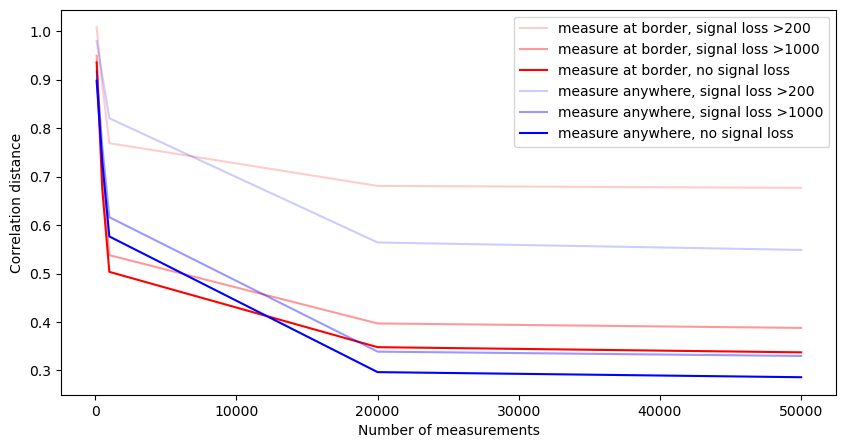

In [222]:
fig, ax = plt.subplots(ncols=1, figsize=(10,5))
# ax.plot(number_of_lines_estimation, correlation_baseline, label="baseline")
for i, loss in enumerate(correlation_border_losses):
    ax.plot(number_of_lines_estimation, loss, color='red', alpha=float(float(i+1)/float(len(loss))), label="measure at border, signal loss >" + str(signal_losses_estimation[i]))
ax.plot(number_of_lines_estimation, correlation_border, label="measure at border, no signal loss", color='red')
for i, loss in enumerate(correlation_anywhere_losses):
    ax.plot(number_of_lines_estimation, loss, color='blue', alpha=float(float(i+1)/float(len(loss))), label="measure anywhere, signal loss >" + str(signal_losses_estimation[i]))
ax.plot(number_of_lines_estimation, correlation_anywhere, color='blue', label="measure anywhere, no signal loss")
ax.set_xlabel('Number of measurements')
ax.set_ylabel('Correlation distance')
plt.legend()
plt.show()